In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer
from quantbullet.dfutils import get_bins_and_labels

## Single Feature Classification Problem

In [2]:
np.random.seed(42)
n_samples = 100_000
x1 = np.random.uniform(0, 4, n_samples)
y = ( x1 - 2 ) ** 2 + np.random.normal(0, 1, n_samples) + 10
df = pd.DataFrame({'x1': x1, 'y': y})

In [3]:
x1_trans = FlatRampTransformer(
    knots = [0.5, 1, 2, 3, 3.5],
    include_bias=True
)

train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() )

In [4]:
x1_bins, x1_labels = get_bins_and_labels(cutoffs=np.arange(0.2, 4, 0.2))
df['x1_bins'] = pd.cut( df['x1'], bins=x1_bins, labels=x1_labels )

In [5]:
feature_groups = {'x1': x1_trans.get_feature_names_out().tolist()}

In [6]:
probs = 1 / (1 + np.exp(-(df['y'] - 16)))
df['binary_y'] = np.random.binomial(1, probs)
print(df['binary_y'].mean())

0.02831


In [7]:
from quantbullet.optimizer import LinearProductClassifierScipy

lpc_scipy = LinearProductClassifierScipy(ftol=1e-8, gtol=1e-8, eps=1e-3)

In [8]:
lpc_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups )

Using initial params: {'x1': array([0.00087505, 0.00041018, 0.00079288, 0.00142165, 0.00207786,
       0.00270674, 0.0030895 ])}
Iter 1: 12142.85372412302
Iter 2: 12128.790298426831
Iter 3: 12124.368434534588
Iter 4: 12120.169330242812
Iter 5: 12088.910818249935
Iter 6: 11955.241755669846
Iter 7: 11863.446192415859
Iter 8: 11777.379357717122
Iter 9: 11746.483013048728
Iter 10: 11720.685098879347
Iter 11: 11660.527975665445
Iter 12: 11639.049343004583
Iter 13: 11614.784350251692
Iter 14: 11428.943902232499
Iter 15: 11421.156369472807
Iter 16: 11417.910179904964
Iter 17: 11415.673311571776
Iter 18: 11415.487675366145
Iter 19: 11414.76116281782
Iter 20: 11409.890869818093
Iter 21: 11399.383435086896
Iter 22: 11377.065914845496
Iter 23: 11338.137630542544
Iter 24: 11322.768075140139
Iter 25: 11297.464665984859
Iter 26: 11287.07015110439
Iter 27: 11285.437439182491
Iter 28: 11285.185097215814
Iter 29: 11284.25410809086
Iter 30: 11283.71045401759
Iter 31: 11283.019828344437
Iter 32: 11281.64

In [9]:
df['clf_scipy_pred_prob'] = lpc_scipy.predict(train_df)

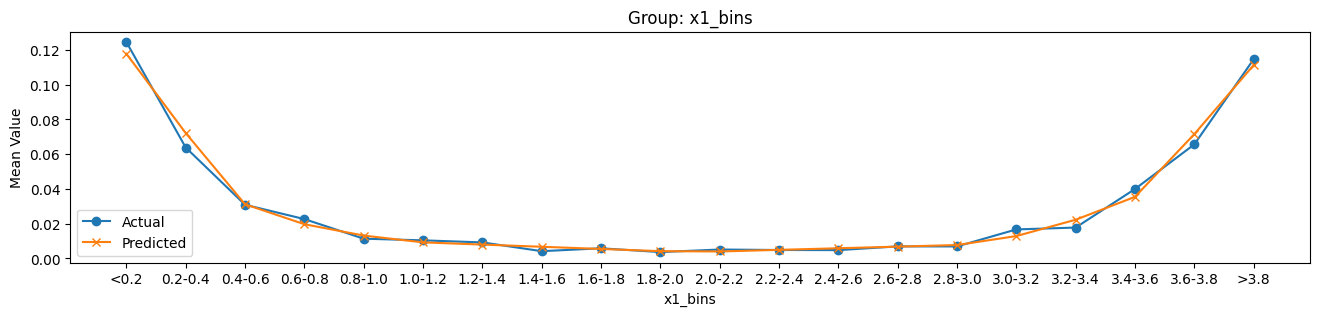

In [10]:
for group in ['x1_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'clf_scipy_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['clf_scipy_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## BCD Optimization

In [16]:
from quantbullet.optimizer import LinearProductClassifierBCD

lpc_bcd = LinearProductClassifierBCD()

In [20]:
lpc_bcd.fit( train_df, df['binary_y'], feature_groups=feature_groups, n_iterations=5 )

Using initial params: {'x1': array([0.00087505, 0.00041018, 0.00079288, 0.00142165, 0.00207786,
       0.00270674, 0.0030895 ])}
Iteration 1/5, Loss: 0.1965
Iteration 2/5, Loss: 6.7122
Iteration 3/5, Loss: 0.1965
Iteration 4/5, Loss: 6.7122
Iteration 5/5, Loss: 0.1965


In [21]:
df['clf_bcd_pred_prob'] = lpc_bcd.predict(train_df)

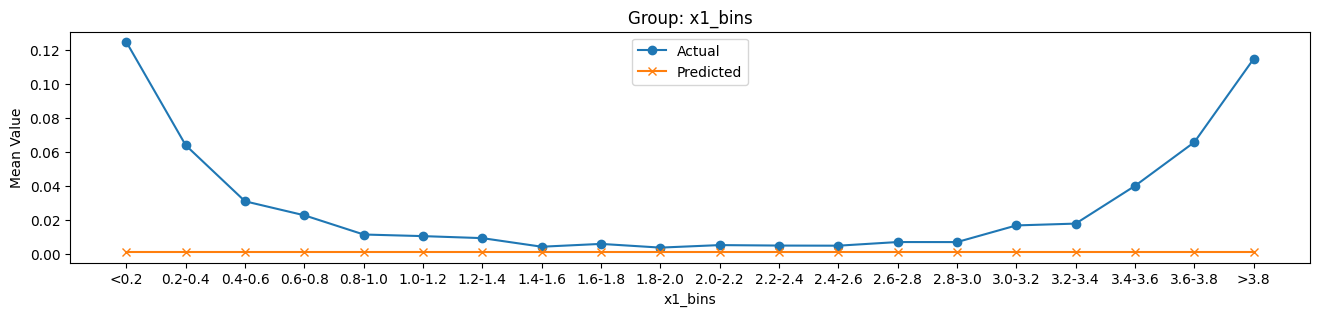

In [22]:
for group in ['x1_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'clf_bcd_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['clf_bcd_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()